In [30]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")  

Using GPU: NVIDIA GeForce RTX 5060


In [31]:

import warnings

warnings.filterwarnings('ignore')

In [32]:
# imports for data handling and visualization

import joblib
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [33]:
# Read data
train_data = pd.read_csv("C:\\Users\\kyle0\\OneDrive\\바탕 화면\\Kaggle\\Kaggle-Predicting_Loan_Payback\\playground-series-s5e11\\train.csv")
test_data = pd.read_csv("C:\\Users\\kyle0\\OneDrive\\바탕 화면\\Kaggle\\Kaggle-Predicting_Loan_Payback\\playground-series-s5e11\\test.csv")
print("Load All Data")

Load All Data


In [34]:
# Check first 5 rows 
train_data.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


# Check features

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


Visualize Categorical Features


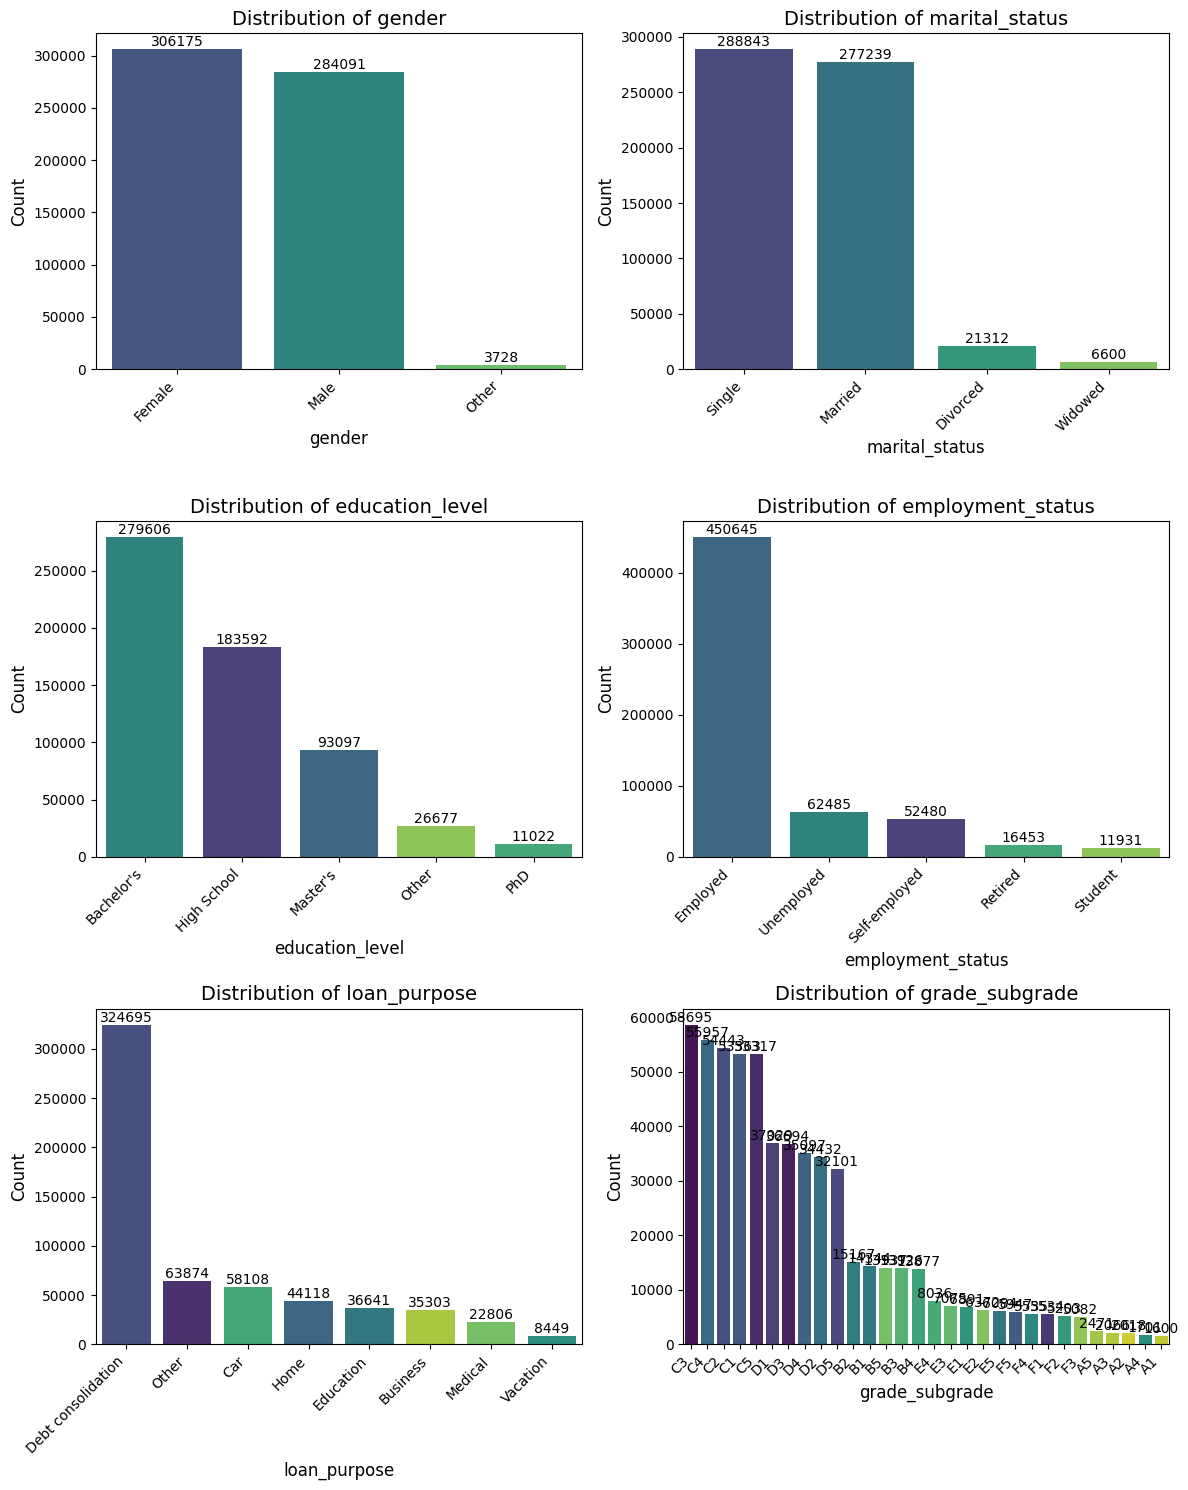

In [36]:
# Check categorical features

cat_attribs = train_data.select_dtypes(include=['object']).columns.tolist()
num_attribs = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Visualize Categorical Features")
n_cols = 2 
n_rows = (len(cat_attribs) + n_cols - 1) // n_cols 

plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, attrib in enumerate(cat_attribs):

    plt.subplot(n_rows, n_cols, i + 1)
    
    sns.countplot(x=attrib, 
                  data=train_data, 
                  order=train_data[attrib].value_counts().index,
                  palette='viridis',
                  hue=attrib, 
                  legend=False 
                 )
    
    plt.title(f'Distribution of {attrib}', fontsize=14)
    plt.xlabel(attrib, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    
    for container in plt.gca().containers:
        plt.bar_label(container)

plt.tight_layout()
plt.show()

In [37]:
# Check summary statistics for numerical features
train_data.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442236,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


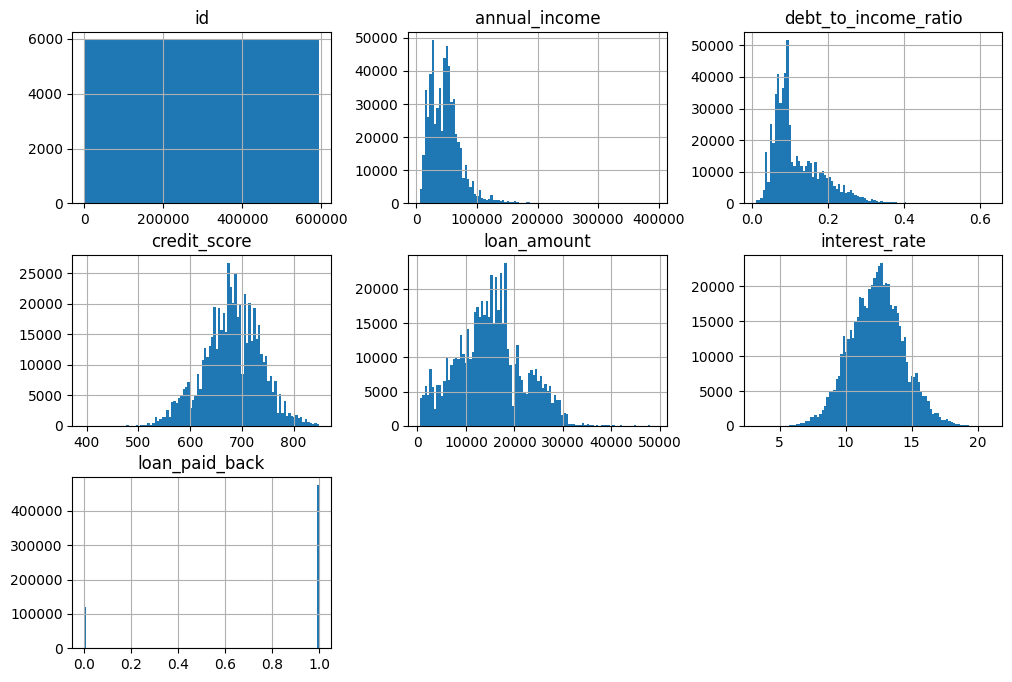

Log transformation is required for the annual_income feature and debt_to_income_ratio


In [38]:
# Draw histograms for numerical features.
train_data.hist(bins=100, figsize=(12, 8))
plt.show()

print("Log transformation is required for the annual_income feature and debt_to_income_ratio")

# EDA

In [39]:
train_data_copy = train_data.copy()

In [40]:
corr_matrix = train_data_copy.corr(numeric_only=True)
corr_matrix['loan_paid_back']

id                      0.001387
annual_income           0.006326
debt_to_income_ratio   -0.335680
credit_score            0.234560
loan_amount            -0.003762
interest_rate          -0.131184
loan_paid_back          1.000000
Name: loan_paid_back, dtype: float64

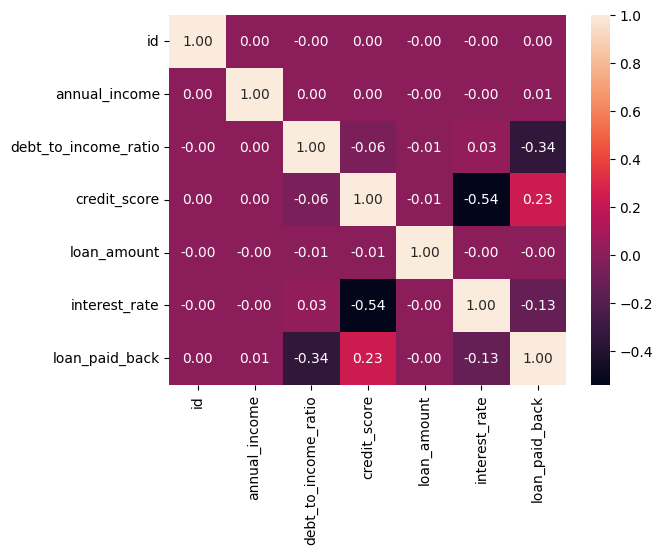

In [41]:
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

# Data Preprocessing

In [42]:
from sklearn.model_selection import train_test_split

X = train_data_copy.drop("loan_paid_back", axis=1)
y = train_data_copy["loan_paid_back"].copy()

# Store Ids
train_ids = train_data_copy["id"].copy()
X = X.drop("id", axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [43]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer


# Preprocessing pipelines for both numeric and categorical data.

num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

def get_custom_feature_names(transformer, input_features):
    return input_features

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, validate=True, feature_names_out=get_custom_feature_names),
    StandardScaler(),
)

preprocessing = ColumnTransformer([
        ("log", log_pipeline, ['annual_income','debt_to_income_ratio']),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder=num_pipeline
)

In [44]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Create pipelines for different classifiers
RF_classifier = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
XGB_classifier = make_pipeline(preprocessing, XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.1, n_jobs=-1))
LGBM_classifier = make_pipeline(preprocessing, LGBMClassifier(n_estimators=100, random_state=42, learning_rate=0.1, n_jobs=-1))

print("Pipeline creation is completed.")

Pipeline creation is completed.


In [45]:
from sklearn.model_selection import cross_val_score

# Evaluate models using cross-validation and AUC metric

RF_scores = cross_val_score(
    estimator=RF_classifier, 
    X=train_X, 
    y=train_y, 
    cv=3, 
    scoring='roc_auc',  
    n_jobs=-1
)
print("\n--- RF_classifier AUC 결과 ---")
print("개별 폴드 AUC 점수:", RF_scores)
print(f"평균 교차 검증 AUC (CV={3}): **{RF_scores.mean():.4f}**")
print(f"점수의 표준 편차: {RF_scores.std():.4f}")
print("\n")

XGB_scores = cross_val_score(
    estimator=XGB_classifier, 
    X=train_X, 
    y=train_y, 
    cv=3, 
    scoring='roc_auc',  
    n_jobs=-1
)
print("\n--- XGB_classifier AUC 결과 ---")
print("개별 폴드 AUC 점수:", XGB_scores)
print(f"평균 교차 검증 AUC (CV={3}): **{XGB_scores.mean():.4f}**")
print(f"점수의 표준 편차: {XGB_scores.std():.4f}")
print("\n") 

LGBM_scores = cross_val_score(
    estimator=LGBM_classifier, 
    X=train_X, 
    y=train_y, 
    cv=3, 
    scoring='roc_auc',  
    n_jobs=-1
)
print("\n--- LGBM_classifier AUC 결과 ---")
print("개별 폴드 AUC 점수:", LGBM_scores)
print(f"평균 교차 검증 AUC (CV={3}): **{LGBM_scores.mean():.4f}**")
print(f"점수의 표준 편차: {LGBM_scores.std():.4f}")
print("\n") 


--- RF_classifier AUC 결과 ---
개별 폴드 AUC 점수: [0.90357322 0.90525977 0.90432989]
평균 교차 검증 AUC (CV=3): **0.9044**
점수의 표준 편차: 0.0007



--- XGB_classifier AUC 결과 ---
개별 폴드 AUC 점수: [0.91693219 0.91829706 0.91745812]
평균 교차 검증 AUC (CV=3): **0.9176**
점수의 표준 편차: 0.0006



--- LGBM_classifier AUC 결과 ---
개별 폴드 AUC 점수: [0.9186064  0.9196118  0.91862887]
평균 교차 검증 AUC (CV=3): **0.9189**
점수의 표준 편차: 0.0005




In [46]:
# Fit the models on the entire training data

RF_classifier.fit(train_X, train_y)
XGB_classifier.fit(train_X, train_y)
LGBM_classifier.fit(train_X, train_y)

print("Model fitting is completed.")

[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
Model fitting is completed.


# Hyperparameter Tuning

In [47]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for LGBMClassifier using GridSearchCV

full_pipeline = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('model', LGBMClassifier(random_state=42)),
    ]
)

param_grid = [
    {
        'model__n_estimators': [100, 1000],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [-1, 10, 100]
    }
]

grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train_X, train_y)
print("Grid search is completed.")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1384
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
Grid search is completed.


In [48]:
# Get the best model from grid search

final_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': -1, 'model__n_estimators': 1000}


In [49]:
# Feature importance extraction

feature_importances = final_model.named_steps['model'].feature_importances_
feature_names = final_model["preprocessing"].get_feature_names_out()
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
print("Feature importances computed.")
print(importances_df)

Feature importances computed.
                                 Feature  Importance
1              log__debt_to_income_ratio        6032
59              remainder__interest_rate        4526
58                remainder__loan_amount        4423
57               remainder__credit_score        4354
0                     log__annual_income        4338
9        cat__education_level_Bachelor's         353
21  cat__loan_purpose_Debt consolidation         348
6            cat__marital_status_Married         296
18     cat__employment_status_Unemployed         290
7             cat__marital_status_Single         272
10      cat__education_level_High School         251
3                       cat__gender_Male         230
2                     cat__gender_Female         228
11         cat__education_level_Master's         200
25               cat__loan_purpose_Other         196
17        cat__employment_status_Student         194
14       cat__employment_status_Employed         182
20              

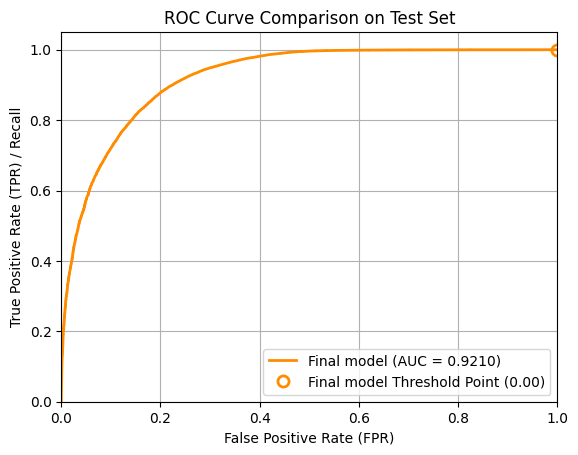

In [50]:
from sklearn.metrics import roc_curve, auc

# ROC Curve comparison on the test set

models = {
    'Final model': final_model
}

colors = ['darkorange'] 

for (name, model), color in zip(models.items(), colors):
    
    y_proba = model.predict_proba(test_X)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_y, y_proba)
    roc_auc = auc(fpr, tpr) 
    
    plt.plot(fpr, tpr, 
             color=color, 
             lw=2, 
             label=f'{name} (AUC = {roc_auc:.4f})')
    
    close_zero = np.argmin(np.abs(thresholds)) 
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=8,
             label=f'{name} Threshold Point ({thresholds[close_zero]:.2f})', 
             fillstyle="none", 
             c=color, 
             mew=2,
             linestyle='None') 


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve Comparison on Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [51]:
import joblib
import os

# Serialization

MODEL_SAVE_PATH = 'final_lgbm_pipeline.pkl'

print(f"모델 저장 시작: {MODEL_SAVE_PATH}")
joblib.dump(final_model, MODEL_SAVE_PATH)
print(f"Saving model finished. File Size: {os.path.getsize(MODEL_SAVE_PATH) / (1024*1024):.2f} MB")

모델 저장 시작: final_lgbm_pipeline.pkl
Saving model finished. File Size: 3.32 MB


# Submission

In [52]:
# Get predictions on the test data and create submission file

preds = model.predict_proba(test_data)[:,1]
submission = pd.read_csv("C:\\Users\\kyle0\\OneDrive\\바탕 화면\\Kaggle\\Kaggle-Predicting_Loan_Payback\playground-series-s5e11\\sample_submission.csv")
submission['loan_paid_back'] = preds
submission.to_csv("C:\\Users\\kyle0\\OneDrive\\바탕 화면\\Kaggle\\Kaggle-Predicting_Loan_Payback\playground-series-s5e11\\sample_submission.csv", index=False)
print("Submission file created.")

Submission file created.
